1주차
===
_p46~62까지_

퍼셉트론

![curriculum](./images/curriculum.png)

In [1]:
"""
!sudo apt install python3-dev graphviz libgraphviz-dev pkg-config
%pip install graphviz
"""

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from typing import List
import logging


### 간단한 `AND` 퍼셉트론의 예시
가중치와 편향이 들어간 간단한 형태의 '뉴런'임을 볼 수 있다

`netwkorkx`는 이후코드 참조용 그리고 이쁘게 보이게 :)

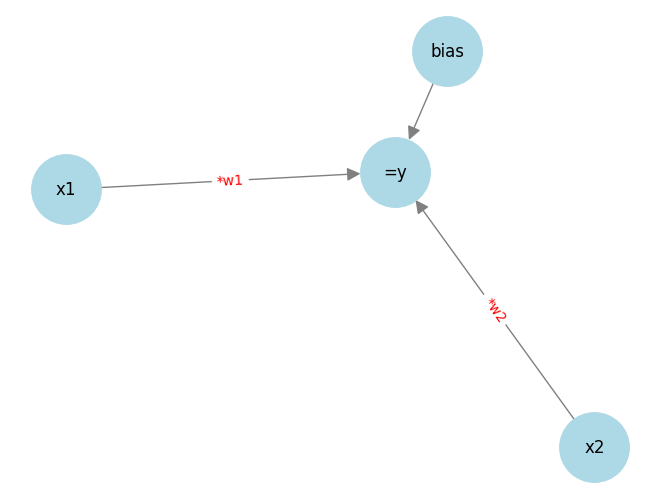

In [2]:
G = nx.DiGraph()
x1, x2, y = "x1", "x2", "=y"
G.add_edges_from([(x1, y), (x2, y)], len=1)
G.add_edge("bias", y, len=.4)

pos = nx.nx_agraph.graphviz_layout(G, prog='neato')

nx.draw(G, pos, 
        with_labels=True, 
        node_color='lightblue', node_size=2500,
        edge_color='gray',
        arrows=True, arrowstyle='-|>', arrowsize=20)

edge_labels = {(x1, y): '*w1', (x2, y): '*w2'}

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.show()

### 좀 더 쉬운(?) 시각화를 위한 미니 프레임워크(?)

각 노드를 class로 만들어서 서로 chaining/적층이 가능하도록

상속통해서 새 노드형태 구현은 쉽도록!

In [3]:
class BaseNode:
    def __init__(self, 
                 inputs: List['BaseNode'] | np.ndarray,
                 name: str = None,
                 weights: np.ndarray = None, 
                 bias: np.float64 = None,
                 theta: np.float64 = None,
                 graph: nx.classes.digraph.DiGraph = None,
                 log_level: int = logging.DEBUG) -> None:
        self.name = name
        self.inputs = inputs
        self.graph = graph  # DC가 아니라 레퍼런스 참조라 이래도 ㄱㅊ

        # input노드이냐 히든 노드이냐
        self.is_input: bool = isinstance(inputs, np.ndarray)
        # print(name, inputs, self.is_input)

        # is_input 따라 알아서 인풋타입 처리, 이따 일처리 쉽게 val만 빼서서
        self.input_vals = inputs if self.is_input else np.array([inp.get_output() for inp in inputs])

        # optional한 계산용 파라미터
        self.weights = weights
        self.bias = bias
        self.theta = theta

        # input수와 weight수 맞는지 확인
        if weights is not None:
            assert len(inputs) == len(weights)
        
        # 로거 실행 (ipynb에선 잘 안되는 듯듯)
        # logging.basicConfig(level=log_level, 
        #                     format=f"%(asctime)s | {self.name} | %(levelname)s | %(message)s")
        # logging.getLogger().addHandler(logging.StreamHandler())
        # self.logger = logging.getLogger(__name__)

    def get_output(self) -> np.float64:
        res = np.sum(self.input_vals * self.weights) + self.bias
        # print(f'{self.theta} | {res} = sum({self.input_vals} * {self.weights}) + {self.bias}')
        return .0 if res <= self.theta else 1.0
    
    def plot_graph(self) -> 'BaseNode':  # 노드 간 traversal 문제때문에 안그려짐;;;;
        # networkx 부분, `not self.is_input` 검수는 ndarray 직접입력을 그래핑할수는 없기에...
        if self.graph is not None and not self.is_input:
            self.graph.add_node(self, label=self.name)
            # input node(들) 추가, input_node -> self (directional)
            self.graph.add_edges_from(
                [(inp, self, {'label': f'w*{w}'}) for inp, w in zip(self.inputs, self.weights)], len=1)
            # bias node 추가 (있다면면)
            if self.bias:
                self.graph.add_edge(f'b*{self.bias}', self, len=.3)
            
            [inp.plot_graph() for inp in self.inputs]
        
        return self
    
    def draw_graph(self) -> None:
        assert self.graph is not None, 'graph가 존재하지 않음!'
        # self.logger.debug(f'self.graph: {self.graph}')
        pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
        nx.draw(self.graph, pos, 
                with_labels=True, 
                node_color='lightblue', node_size=2500,
                edge_color='gray',
                arrows=True, arrowstyle='-|>', arrowsize=20)


class InputNode(BaseNode):
    def __init__(self, name, inputs, weights, bias):
        super().__init__(name, inputs, weights, bias)
        assert self.is_input, '인풋노드는 수가 들어있어야함 (np.ndarray)'
    
    def get_output(self):
        return self.input_vals

note: 상속받는 operator node의 `__init__` 변수들 `__init__`시에 변경은 가능하게 함 혹시나해서

<div class="alert alert-block alert-danger">
<b>잘못만듦...</b> <br>계산은 다 작동 잘 하는데, 계산 전파 방향을 반대로 만들어서 그래프 안그려짐...
</div>

#### `AND` 구현

In [4]:
class AND(BaseNode):
    def __init__(self,
                 weights = np.array([.5, .5]),
                 bias = -.7,
                 theta = 0,
                 **kwargs):
        super().__init__(weights=weights, bias=bias, theta=theta, **kwargs)

In [5]:
AND(inputs=np.array([0, 0])).get_output(),\
AND(inputs=np.array([0, 1])).get_output(),\
AND(inputs=np.array([1, 0])).get_output(),\
AND(inputs=np.array([1, 1])).get_output()

(0.0, 0.0, 0.0, 1.0)

DiGraph with 0 nodes and 0 edges


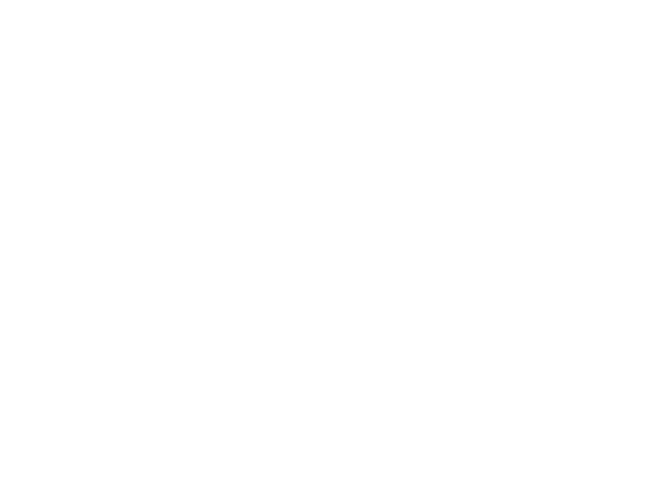

In [6]:
graph = nx.DiGraph()
print(graph)
AND(inputs=np.array([1, 1]), graph=graph).draw_graph()

#### `NAND` 구현

In [7]:
class NAND(BaseNode):
    def __init__(self,
                 weights = np.array([-.5, -.5]),
                 bias = .7,
                 theta = 0,
                 **kwargs):
        # AND에서 weight, bias 역으로
        super().__init__(weights=weights, bias=bias, theta=theta, **kwargs)

In [8]:
NAND(inputs=np.array([0, 0])).get_output(),\
NAND(inputs=np.array([0, 1])).get_output(),\
NAND(inputs=np.array([1, 0])).get_output(),\
NAND(inputs=np.array([1, 1])).get_output()

(1.0, 1.0, 1.0, 0.0)

#### `OR` 구현

In [9]:
class OR(BaseNode):
    def __init__(self,
                 weights = np.array([.5, .5]),
                 bias = -.2,
                 theta = 0,
                 **kwargs):
        super().__init__(weights=weights, bias=bias, theta=theta, **kwargs)

In [10]:
OR(inputs=np.array([0, 0])).get_output(),\
OR(inputs=np.array([0, 1])).get_output(),\
OR(inputs=np.array([1, 0])).get_output(),\
OR(inputs=np.array([1, 1])).get_output()

(0.0, 1.0, 1.0, 1.0)

#### `XOR` 구현 (적층!)

In [11]:
class XOR(BaseNode):
    def get_output(self) -> np.ndarray:
        return AND(inputs=[NAND(inputs=self.input_vals), OR(inputs=self.input_vals)]).get_output()

In [12]:
XOR(inputs=np.array([0, 0])).get_output(),\
XOR(inputs=np.array([1, 0])).get_output(),\
XOR(inputs=np.array([0, 1])).get_output(),\
XOR(inputs=np.array([1, 1])).get_output()

(0.0, 1.0, 1.0, 0.0)

In [13]:
# XOR(inputs=np.array([1, 1]), graph=graph).plot_graph().draw_graph()
AND(inputs=[NAND(inputs=np.array([1, 1]), name="NAND"), OR(inputs=np.array([1, 1]), name="OR")], name="AND").get_output()

0.0

이런식으로 만들어도 됨!

In [14]:
def xor(inp: np.ndarray) -> None:
    print(AND(inputs=[NAND(inputs=inp), OR(inputs=inp)]).get_output())

xor(np.array([0, 0]))
xor(np.array([0, 1]))
xor(np.array([1, 0]))
xor(np.array([1, 1]))

0.0
1.0
1.0
0.0


![ㅈㄱㄴ](./images/W2/Screenshot%202025-03-20%20145123.png)

- (거의) 모든 형태의 논리로직을 NAND로 표현할 수 있음 (다 그렇게 쓰고있다는건 아니지만)\
- AND, OR, NOR보다 이것저것 회로를 만드는데 더 작고 효율적이게 할 수 있음
- SR-Latch같은데에 써서 메모리 만드는데 자주사용